# Neural Networks with PyTorch
Note: This notebook will be used for nn as an educational extension and will compare its performance. For this dataset, since it is small and tabular, a tree-based model may be more appropriate.  


### Model Selection
Since our dataset is small, from research we have determined that a smal feed-forward MLP would be a good candidate.  

A shallow MLP gives a flexible nonlinear decision boundary (via ReLU) while keeping cariance controlled through small width, dropout/L2, and early stopping.  

Moreover, MLPs learn smooth functions and with standardized tabular inputs, this may be beneficial.  

A compact MLP will introduce enough nonlinearity to model interactiosn in the 12 clinical features but keep capacity, variance, and training instability in check.

In [64]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, precision_score, recall_score, auc, fbeta_score


from skorch import NeuralNetBinaryClassifier
from sklearn.model_selection import GridSearchCV

## Data Preparation and Loading 

In [65]:
# Load data - splits were created in previous notebook 
X_train = pd.read_csv("../data/X_train.csv")
y_train = pd.read_csv("../data/y_train.csv").values.ravel()  # Convert to 1D array

X_val = pd.read_csv("../data/X_val.csv")
y_val = pd.read_csv("../data/y_val.csv").values.ravel()  # Convert to 1D array

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in validation: {np.bincount(y_val)}")

Training set: 179 samples
Validation set: 45 samples
Class distribution in training: [130  49]
Class distribution in validation: [33 12]


In [66]:
continuous_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

In [67]:
# Column Transformer + Pipeline to standardize data 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

In [68]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)


## PyTorch Tensors

In [69]:
# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train Tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

# Validation Tensors
X_val_tensor = torch.tensor(X_val_processed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # shuffle=True prevents model from seeign data in the same order every time,
                                                                      # reducing correlation between successive batches and improving stochastic optimization.
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        

## Create Torch model 

Simple shallow MLP network class implementation below. We are using a limited number of neurons to prevent overfitting risk as a 32 -> 16 MLP keeps total params at 1232+3216+161 plus biases.

In [70]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden1=32, hidden2=16, p_drop=0.2):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden2, 1),
            nn.Sigmoid() # For binary classificatio
        )
    
    def forward(self, x):
        return self.net(x)
        

In [71]:
nn_model = MLP(in_features=X_train_processed.shape[1]).to(device)

# Loss and Optimizer 
pos_weight = torch.tensor(len(y_train) / y_train.sum())
criterion = nn.BCELoss(weight=None)
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

In [72]:
# Training Loop
def evaluate(loader):
    nn_model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = nn_model(xb)
            preds.append(out.cpu().numpy())
            targets.append(yb.cpu().numpy())
    preds = np.vstack(preds).ravel()
    targets = np.vstack(targets).ravel()
    return {
        "auc": roc_auc_score(targets, preds),
        "f1": f1_score(targets, preds >= 0.5),
        "acc": accuracy_score(targets, preds >= 0.5)
    }

epochs = 100
best_auc = -np.inf
for epoch in range(1, epochs + 1):
    nn_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = nn_model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        metrics = evaluate(val_loader)
        if metrics["auc"] > best_auc:
            best_auc = metrics["auc"]
        print(f"Epoch {epoch:03d} | val_auc={metrics['auc']:.3f} val_f1={metrics['f1']:.3f} val_acc={metrics['acc']:.3f}")

# Final evaluation
val_metrics = evaluate(val_loader)
print("Final validation:", val_metrics)

Epoch 001 | val_auc=0.629 val_f1=0.000 val_acc=0.733
Epoch 010 | val_auc=0.813 val_f1=0.000 val_acc=0.733
Epoch 020 | val_auc=0.836 val_f1=0.375 val_acc=0.778
Epoch 030 | val_auc=0.831 val_f1=0.455 val_acc=0.733
Epoch 040 | val_auc=0.833 val_f1=0.522 val_acc=0.756
Epoch 050 | val_auc=0.836 val_f1=0.522 val_acc=0.756
Epoch 060 | val_auc=0.838 val_f1=0.522 val_acc=0.756
Epoch 070 | val_auc=0.843 val_f1=0.522 val_acc=0.756
Epoch 080 | val_auc=0.848 val_f1=0.522 val_acc=0.756
Epoch 090 | val_auc=0.854 val_f1=0.583 val_acc=0.778
Epoch 100 | val_auc=0.859 val_f1=0.522 val_acc=0.756
Final validation: {'auc': 0.8585858585858586, 'f1': 0.5217391304347826, 'acc': 0.7555555555555555}


In [73]:
# Cast processed arrays to float32 before skorch/torch to avoid dtype mismatch
X_train_f = X_train_processed.astype(np.float32)
X_val_f = X_val_processed.astype(np.float32)
y_train_f = y_train.astype(np.float32)



## Cross Validation and Threshold Optimization

In [74]:
net = NeuralNetBinaryClassifier(
    module=MLP,
    module__in_features=X_train_f.shape[1],
    criterion=nn.BCELoss,
    optimizer=optim.Adam,
    max_epochs=100,
    lr=0.001,
    device=device,
    train_split=False,
    verbose=0,
)

params = {
    "module__hidden1": [32, 16],
    "module__hidden2": [16, 8],
    "module__p_drop": [0.05, 0.1, 0.2],
    "lr": [1e-3, 5e-4],
}

gs = GridSearchCV(
    net,
    params,
    cv=5,
    scoring="roc_auc",
    verbose=0,
)

# Use float32 inputs to match model weights
gs.fit(X_train_f, y_train_f)



,estimator,"<class 'skorc...features=12, )"
,param_grid,"{'lr': [0.001, 0.0005], 'module__hidden1': [32, 16], 'module__hidden2': [16, 8], 'module__p_drop': [0.05, 0.1, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,module,<class '__main__.MLP'>


In [75]:
# Explicit threshold sweep (mirrors 03-ml-and-predictions)
best_net = gs.best_estimator_
val_probs = best_net.predict_proba(X_val_f)[:, 1]

thresholds = np.linspace(0.1, 0.9, 17)
print("NN - Threshold Tuning Results:")
print("="*70)
threshold_results_nn = []

for t in thresholds:
    y_pred_t = (val_probs >= t).astype(int)
    recall_t = recall_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    precision_t = precision_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    f1_t = f1_score(y_val, y_pred_t, pos_label=1, zero_division=0)
    acc_t = accuracy_score(y_val, y_pred_t)
    threshold_results_nn.append({
        'threshold': t,
        'recall': recall_t,
        'precision': precision_t,
        'f1': f1_t,
        'acc': acc_t
    })
    print(f"t={t:.2f} | Recall={recall_t:.3f} | Precision={precision_t:.3f} | F1={f1_t:.3f} | Acc={acc_t:.3f}")

print("="*70)
threshold_df_nn = pd.DataFrame(threshold_results_nn)
best_threshold_nn = threshold_df_nn.loc[threshold_df_nn['f1'].idxmax()]

best_t = best_threshold_nn['threshold']
best_f1 = best_threshold_nn['f1']
val_preds_opt = (val_probs >= best_t).astype(int)

print(f"\nBest threshold for NN (max F1): {best_t:.3f}")
print(f"  Recall: {best_threshold_nn['recall']:.3f}")
print(f"  Precision: {best_threshold_nn['precision']:.3f}")
print(f"  F1 Score: {best_f1:.3f}")



NN - Threshold Tuning Results:
t=0.10 | Recall=1.000 | Precision=0.480 | F1=0.649 | Acc=0.711
t=0.15 | Recall=0.917 | Precision=0.478 | F1=0.629 | Acc=0.711
t=0.20 | Recall=0.833 | Precision=0.556 | F1=0.667 | Acc=0.778
t=0.25 | Recall=0.833 | Precision=0.588 | F1=0.690 | Acc=0.800
t=0.30 | Recall=0.583 | Precision=0.538 | F1=0.560 | Acc=0.756
t=0.35 | Recall=0.583 | Precision=0.583 | F1=0.583 | Acc=0.778
t=0.40 | Recall=0.500 | Precision=0.545 | F1=0.522 | Acc=0.756
t=0.45 | Recall=0.500 | Precision=0.545 | F1=0.522 | Acc=0.756
t=0.50 | Recall=0.417 | Precision=0.500 | F1=0.455 | Acc=0.733
t=0.55 | Recall=0.417 | Precision=0.556 | F1=0.476 | Acc=0.756
t=0.60 | Recall=0.333 | Precision=0.500 | F1=0.400 | Acc=0.733
t=0.65 | Recall=0.333 | Precision=0.500 | F1=0.400 | Acc=0.733
t=0.70 | Recall=0.333 | Precision=0.667 | F1=0.444 | Acc=0.778
t=0.75 | Recall=0.167 | Precision=0.500 | F1=0.250 | Acc=0.733
t=0.80 | Recall=0.167 | Precision=1.000 | F1=0.286 | Acc=0.778
t=0.85 | Recall=0.167 | 

In [76]:
# Predict with best estimator on val
best_net = gs.best_estimator_
val_probs = best_net.predict_proba(X_val_f)[:, 1]


In [77]:

def find_best_threshold(y_true, probs, metric=f1_score, grid=np.linspace(0.1, 0.9, 17)):
    best_t, best_m = 0.5, -1
    for t in grid:
        preds = (probs >= t).astype(int)
        m = metric(y_true, preds)
        if m > best_m:
            best_m, best_t = m, t
    return best_t, best_m

def find_best_fbeta(y_true, probs, beta=0.5, grid=np.linspace(0.1, 0.9, 17)):
    # beta <1 favors precision, >1 favors recall
    best_t, best_m = 0.5, -1
    for t in grid:
        preds = (probs >= t).astype(int)
        m = fbeta_score(y_true, preds, beta=beta)
        if m > best_m:
            best_m, best_t = m, t
    return best_t, best_m

best_t, best_f1 = find_best_threshold(y_val, val_probs, metric=f1_score)
val_preds_opt = (val_probs >= best_t).astype(int)

# Optional: best threshold favoring precision (F0.5)
best_t_f05, best_f05 = find_best_fbeta(y_val, val_probs, beta=0.5)
val_preds_f05 = (val_probs >= best_t_f05).astype(int)

val_auc = roc_auc_score(y_val, val_probs)
val_acc = accuracy_score(y_val, val_preds_opt)
val_precision = precision_score(y_val, val_preds_opt)
val_recall = recall_score(y_val, val_preds_opt)

print(f"Best CV ROC AUC: {gs.best_score_:.3f}")
print(f"Best Params: {gs.best_params_}")
print(f"Best threshold (max F1): {best_t:.2f}")
print(f"Val AUC: {val_auc:.3f}")
print(f"Val F1: {best_f1:.3f}  Val Precision: {val_precision:.3f}  Val Recall: {val_recall:.3f}  Val Acc: {val_acc:.3f}")
print(f"Best threshold (F0.5, precision-weighted): {best_t_f05:.2f} | F0.5={best_f05:.3f}")



Best CV ROC AUC: 0.871
Best Params: {'lr': 0.0005, 'module__hidden1': 32, 'module__hidden2': 16, 'module__p_drop': 0.05}
Best threshold (max F1): 0.25
Val AUC: 0.848
Val F1: 0.690  Val Precision: 0.588  Val Recall: 0.833  Val Acc: 0.800
Best threshold (F0.5, precision-weighted): 0.25 | F0.5=0.625


In [78]:
# Summary metrics using the swept best threshold (and a precision-leaning option)
val_preds_opt = (val_probs >= best_t).astype(int)
best_t_f05, best_f05 = find_best_fbeta(y_val, val_probs, beta=0.5)
val_preds_f05 = (val_probs >= best_t_f05).astype(int)

val_auc = roc_auc_score(y_val, val_probs)
val_acc = accuracy_score(y_val, val_preds_opt)
val_precision = precision_score(y_val, val_preds_opt)
val_recall = recall_score(y_val, val_preds_opt)

print(f"Best CV ROC AUC: {gs.best_score_:.3f}")
print(f"Best Params: {gs.best_params_}")
print(f"Best threshold (max F1): {best_t:.2f}")
print(f"Val AUC: {val_auc:.3f}")
print(f"Val F1: {best_f1:.3f}  Val Precision: {val_precision:.3f}  Val Recall: {val_recall:.3f}  Val Acc: {val_acc:.3f}")
print(f"Best threshold (F0.5, precision-weighted): {best_t_f05:.2f} | F0.5={best_f05:.3f}")



Best CV ROC AUC: 0.871
Best Params: {'lr': 0.0005, 'module__hidden1': 32, 'module__hidden2': 16, 'module__p_drop': 0.05}
Best threshold (max F1): 0.25
Val AUC: 0.848
Val F1: 0.690  Val Precision: 0.588  Val Recall: 0.833  Val Acc: 0.800
Best threshold (F0.5, precision-weighted): 0.25 | F0.5=0.625


In [79]:
# Final concise summary
print("\n=== Final NN Summary ===")
print(f"Best CV ROC AUC: {gs.best_score_:.3f}")
print(f"Best Params: {gs.best_params_}")
print(f"Val AUC: {val_auc:.3f}")
print(f"Best threshold (F1): {best_t:.3f}")
print(f"Val Precision: {val_precision:.3f}")
print(f"Val Recall: {val_recall:.3f}")
print(f"Val F1: {best_f1:.3f}")
print(f"Val Acc: {val_acc:.3f}")
print(f"Precision-weighted threshold (F0.5): {best_t_f05:.3f} | F0.5={best_f05:.3f}")




=== Final NN Summary ===
Best CV ROC AUC: 0.871
Best Params: {'lr': 0.0005, 'module__hidden1': 32, 'module__hidden2': 16, 'module__p_drop': 0.05}
Val AUC: 0.848
Best threshold (F1): 0.250
Val Precision: 0.588
Val Recall: 0.833
Val F1: 0.690
Val Acc: 0.800
Precision-weighted threshold (F0.5): 0.250 | F0.5=0.625


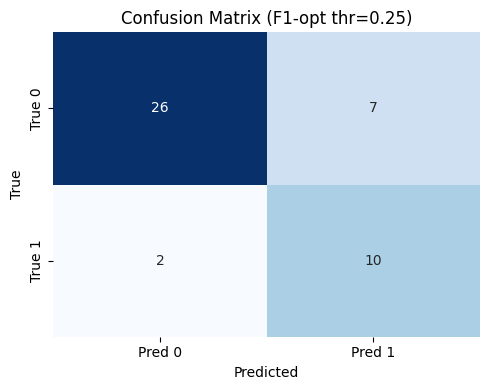

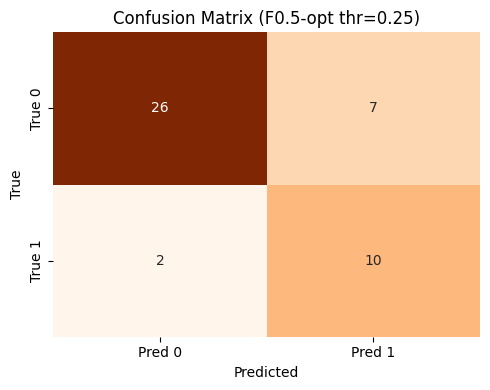

In [80]:
# Confusion matrix at optimized F1 threshold
cm = confusion_matrix(y_val, val_preds_opt)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title(f'Confusion Matrix (F1-opt thr={best_t:.2f})')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

# Confusion matrix at precision-weighted (F0.5) threshold
cm_f05 = confusion_matrix(y_val, val_preds_f05)
plt.figure(figsize=(5,4))
sns.heatmap(cm_f05, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title(f'Confusion Matrix (F0.5-opt thr={best_t_f05:.2f})')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()



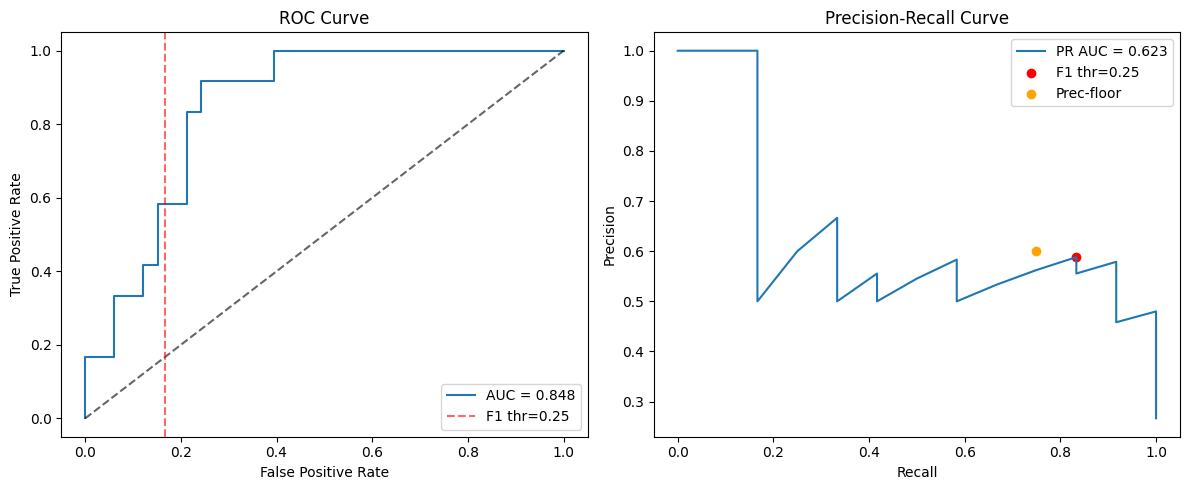

In [81]:
# ROC and Precision-Recall curves
fpr, tpr, _ = roc_curve(y_val, val_probs)
precision, recall, _ = precision_recall_curve(y_val, val_probs)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
axes[0].plot([0,1],[0,1],'k--', alpha=0.6)
axes[0].axvline(x=(1 - val_recall), color='red', linestyle='--', alpha=0.6, label=f'F1 thr={best_t:.2f}')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')

axes[1].plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
axes[1].scatter([val_recall], [val_precision], color='red', label=f'F1 thr={best_t:.2f}')
axes[1].scatter([rec_pf] if 'rec_pf' in locals() else [], [prec_pf] if 'prec_pf' in locals() else [],
                color='orange', label='Prec-floor' if 'prec_pf' in locals() else None)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()



In [82]:
## Final Model Summary

print("="*70)
print("          NEURAL NETWORK MODEL - FINAL SUMMARY")
print("="*70)
print("\n### Cross-Validation Results")
print(f"  Best CV ROC AUC:              {gs.best_score_:.3f}")
print(f"  CV Method:                    5-fold Stratified")

print("\n### Best Hyperparameters")
print(f"  Hidden Layer 1 Size:          {gs.best_params_['module__hidden1']}")
print(f"  Hidden Layer 2 Size:          {gs.best_params_['module__hidden2']}")
print(f"  Dropout Rate:                 {gs.best_params_['module__p_drop']}")
print(f"  Learning Rate:                {gs.best_params_['lr']}")
print(f"  Optimizer:                    Adam")
print(f"  Activation:                   ReLU")
print(f"  Max Epochs:                   100")

print("\n### Validation Set Performance (F1-Optimized Threshold)")
print(f"  ROC AUC:                      {val_auc:.3f}")
print(f"  Optimal Threshold:            {best_t:.3f}")
print(f"  Accuracy:                     {val_acc:.3f}")
print(f"  Precision:                    {val_precision:.3f}")
print(f"  Recall:                       {val_recall:.3f}")
print(f"  F1 Score:                     {best_f1:.3f}")

print("\n### Alternative Threshold (Precision-Weighted, F0.5)")
print(f"  F0.5 Threshold:               {best_t_f05:.3f}")
print(f"  F0.5 Score:                   {best_f05:.3f}")

print("\n### Model Architecture Summary")
print(f"  Input Features:               {X_train_f.shape[1]}")
print(f"  Architecture:                 {X_train_f.shape[1]} → {gs.best_params_['module__hidden1']} → {gs.best_params_['module__hidden2']} → 1")
print(f"  Total Parameters:             ~{X_train_f.shape[1]*gs.best_params_['module__hidden1'] + gs.best_params_['module__hidden1']*gs.best_params_['module__hidden2'] + gs.best_params_['module__hidden2']*1}")
print(f"  Device:                       {device}")

print("\n### Dataset")
print(f"  Training Samples:             {len(X_train_f)}")
print(f"  Validation Samples:           {len(X_val_f)}")
print(f"  Class Balance (Train):        {np.bincount(y_train.astype(int))}")
print(f"  Class Balance (Val):          {np.bincount(y_val)}")

print("="*70)



          NEURAL NETWORK MODEL - FINAL SUMMARY

### Cross-Validation Results
  Best CV ROC AUC:              0.871
  CV Method:                    5-fold Stratified

### Best Hyperparameters
  Hidden Layer 1 Size:          32
  Hidden Layer 2 Size:          16
  Dropout Rate:                 0.05
  Learning Rate:                0.0005
  Optimizer:                    Adam
  Activation:                   ReLU
  Max Epochs:                   100

### Validation Set Performance (F1-Optimized Threshold)
  ROC AUC:                      0.848
  Optimal Threshold:            0.250
  Accuracy:                     0.800
  Precision:                    0.588
  Recall:                       0.833
  F1 Score:                     0.690

### Alternative Threshold (Precision-Weighted, F0.5)
  F0.5 Threshold:               0.250
  F0.5 Score:                   0.625

### Model Architecture Summary
  Input Features:               12
  Architecture:                 12 → 32 → 16 → 1
  Total Parameters:   

## XGBoost significantly outperforms the Neural Network:
ROC AUC: XGBoost achieves 0.944 vs NN's 0.848 (~11% better discrimination)  
Recall: XGBoost catches 91.7% of deaths vs NN's 83.3% (critical for healthcare)  
Precision: XGBoost has 73.3% vs NN's 58.8% (fewer false alarms)  
F1 Score: XGBoost's 0.815 vs NN's 0.690 shows much better overall balance     

## Why XGBoost wins on this dataset:
Small tabular data: Tree-based models (like XGBoost) typically excel on small tabular datasets (<1000 rows)
Feature interactions: XGBoost naturally captures complex feature interactions without needing manual feature engineering
Robustness: Less sensitive to scaling, missing data, and outliers
Sample efficiency: Works better with limited training data (179 samples)  

## Neural Network limitations here:
Data size: NNs typically need 10x-100x more data to reach their potential
Overfitting risk: Even with dropout (0.05) and small architecture (32→16), the NN struggles with generalization
Feature engineering: NNs benefit from raw features in large datasets, but this dataset is already clean/engineered